# 🧪 Free Fall with Noise: Modeling Motion Under Uncertainty

In this notebook, we simulate the vertical motion of a freely falling object and introduce controlled noise to the data. The goal is to explore how well we can recover physically meaningful parameters—like gravitational acceleration—from imperfect observations.

This experiment serves as a bridge between classical physics and modern machine learning, testing the robustness and interpretability of models under noisy conditions.

In [1]:
import torch

## Creating data

In [2]:
start = 0 
end = 10
n_samples = 100
steps = (end - start)/n_samples
t = torch.arange(start, end, steps).unsqueeze(dim=1)

# Constants
a = 4.9
b = 20
c = 300

X = torch.cat([t, t**2], dim = 1)
y = -a*t**2 + b*t + c

## Experiment with 5% Guassian Noise

### Normalizing, Splitting and Adding Noise to the Data

In [3]:
import sys
sys.path.append('../utils')
from experiment_preparation import *

noise_level = 0.05 # 5% 
y_noisy = adding_noise(noise_level,y)

normalized_data = normalization(X, y_noisy)

X_train, y_train, X_test, y_test = splitting_data(normalized_data.X_normalized, normalized_data.y_normalized)

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

### Training the Model (MAE)

In [4]:
from model_architecture import LinearRegressionModel
from train_model import train_model, TrainingConfig

model = LinearRegressionModel()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = torch.nn.L1Loss()


config = TrainingConfig(
    epochs=10000,
    window_size=200,
    patience=3,
    optimizer=optimizer,
    loss_fn=loss_fn,
    verbose=True,
    model_name=f"Best_MAE_Loss_5_Noise"
)
    
losses = train_model(model, X_train, y_train, X_test, y_test, config)

Epoch     0 | Train Loss: 1.462013 | Test Loss: 3.187225
Epoch   200 | Train Loss: 0.199041 | Test Loss: 1.019287
Epoch   400 | Train Loss: 0.180707 | Test Loss: 0.784992
Epoch   600 | Train Loss: 0.166480 | Test Loss: 0.661056
Epoch   800 | Train Loss: 0.155866 | Test Loss: 0.575087
Epoch  1000 | Train Loss: 0.146561 | Test Loss: 0.507972
Epoch  1200 | Train Loss: 0.137944 | Test Loss: 0.461432
Epoch  1400 | Train Loss: 0.130677 | Test Loss: 0.382353
Epoch  1600 | Train Loss: 0.125253 | Test Loss: 0.311740
Epoch  1800 | Train Loss: 0.121120 | Test Loss: 0.255657
Epoch  2000 | Train Loss: 0.118932 | Test Loss: 0.216574
Epoch  2200 | Train Loss: 0.116894 | Test Loss: 0.201909
Epoch  2400 | Train Loss: 0.115627 | Test Loss: 0.189401
Epoch  2600 | Train Loss: 0.115101 | Test Loss: 0.173219
Epoch  2800 | Train Loss: 0.114949 | Test Loss: 0.161343
Epoch  3000 | Train Loss: 0.114828 | Test Loss: 0.159143
Epoch  3200 | Train Loss: 0.114756 | Test Loss: 0.156020
Epoch  3400 | Train Loss: 0.114

### Training the Model (MSE)

In [5]:
from model_architecture import LinearRegressionModel
from train_model import train_model, TrainingConfig

model_mse = LinearRegressionModel()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss_fn = torch.nn.MSELoss()


config = TrainingConfig(
    epochs=10000,
    window_size=200,
    patience=3,
    optimizer=optimizer,
    loss_fn=loss_fn,
    verbose=True,
    model_name=f"Best_MSE_Loss_5_Noise"
)
    
losses_mse = train_model(model, X_train, y_train, X_test, y_test, config)

Epoch     0 | Train Loss: 0.019958 | Test Loss: 0.027910
Epoch   200 | Train Loss: 0.018963 | Test Loss: 0.012073
Epoch   400 | Train Loss: 0.018719 | Test Loss: 0.008372
Epoch   600 | Train Loss: 0.018650 | Test Loss: 0.007460
Epoch   800 | Train Loss: 0.018631 | Test Loss: 0.007271
Epoch  1000 | Train Loss: 0.018625 | Test Loss: 0.007254
Epoch  1200 | Train Loss: 0.018624 | Test Loss: 0.007268
Epoch  1400 | Train Loss: 0.018623 | Test Loss: 0.007282
Early stopping at epoch 1400


### Visualizing The Loss Curves (MAE vs. MSE)

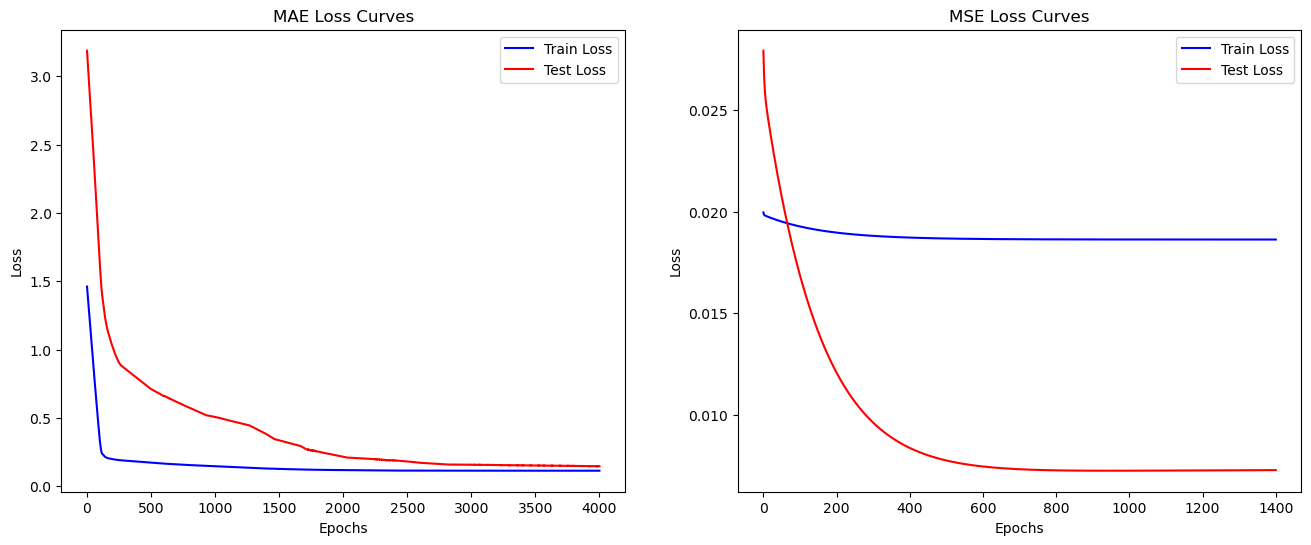

In [6]:
from ploting_utils import plot_loss_curves
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_loss_curves('MAE Loss', range(losses.epochs_run), losses.train_losses, losses.test_losses)
plt.subplot(1,2,2)
plot_loss_curves('MSE Loss', range(losses_mse.epochs_run), losses_mse.train_losses, losses_mse.test_losses)

### Recoverd Parameters (MAE vs. MSE)

In [7]:
from recovered_parameters import recovered_parameters

recovered_parameters(f'Best_MAE_Loss_5_Noise', normalized_data.X_mean, normalized_data.X_std, normalized_data.y_mean, normalized_data.y_std)
recovered_parameters(f'Best_MSE_Loss_5_Noise', normalized_data.X_mean, normalized_data.X_std, normalized_data.y_mean, normalized_data.y_std)

Recovered Physical Parameters (Best_MAE_Loss_5_Noise Loss):
 a = 4.23, b = 14.71, c = 306.81

Recovered Physical Parameters (Best_MSE_Loss_5_Noise Loss):
 a = 4.87, b = 19.67, c = 301.52



### Visualizing the Predictions (MAE vs MSE)

Text(0.5, 1.0, 'Predicted Free Fall Model (MSE 5% Guassian Noise)')

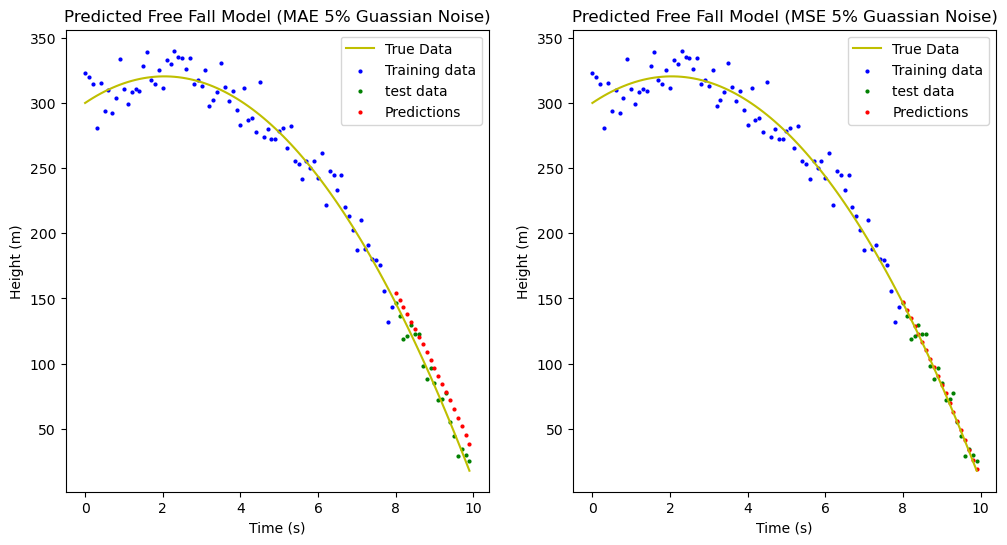

In [8]:
from ploting_utils import plot_predictions
from denormalizing import denormalize_parameters
import matplotlib.pyplot as plt

X_train_denorm = X_train * normalized_data.X_std + normalized_data.X_mean
y_train_denorm = y_train * normalized_data.y_std + normalized_data.y_mean

X_test_denorm = X_test * normalized_data.X_std + normalized_data.X_mean
y_test_denorm = y_test * normalized_data.y_std + normalized_data.y_mean

state_dict = torch.load(f'../models/Best_MAE_Loss_5_Noise.pth', weights_only=True)
model = LinearRegressionModel()
model.load_state_dict(state_dict)
weights = state_dict['linear_layer.weight']
bias = state_dict['linear_layer.bias']

model.eval()
with torch.no_grad():
    preds = model(X_test)

preds_denorm = preds * normalized_data.y_std + normalized_data.y_mean
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(t, y, c ='y', label='True Data')
plot_predictions(X_train_denorm, y_train_denorm, X_test_denorm, y_test_denorm, preds_denorm)
plt.title('Predicted Free Fall Model (MAE 5% Guassian Noise)')

state_dict_mse = torch.load(f'../models/Best_MSE_Loss_5_Noise.pth', weights_only=True)
model_mse = LinearRegressionModel()
model_mse.load_state_dict(state_dict_mse)
weights_mse = state_dict_mse['linear_layer.weight']
bias_mse = state_dict_mse['linear_layer.bias']

model_mse.eval()
with torch.no_grad():
    preds_mse = model_mse(X_test)
preds_denorm_mse = preds_mse * normalized_data.y_std + normalized_data.y_mean
plt.subplot(1,2,2)
plt.plot(t, y, c ='y', label='True Data')
plot_predictions(X_train_denorm, y_train_denorm, X_test_denorm, y_test_denorm, preds_denorm_mse)
plt.title('Predicted Free Fall Model (MSE 5% Guassian Noise)')


## Experiment with 10% Guassian Noise

### Normalizing, Splitting and Adding Noise to the Data

In [9]:
import sys
sys.path.append('../utils')
from experiment_preparation import *

noise_level = 0.1 # 5% 
y_noisy = adding_noise(noise_level,y)

normalized_data = normalization(X, y_noisy)

X_train, y_train, X_test, y_test = splitting_data(normalized_data.X_normalized, normalized_data.y_normalized)

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

### Training the Model (MAE)

In [10]:
from model_architecture import LinearRegressionModel
from train_model import train_model, TrainingConfig

model = LinearRegressionModel()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = torch.nn.L1Loss()


config = TrainingConfig(
    epochs=10000,
    window_size=200,
    patience=3,
    optimizer=optimizer,
    loss_fn=loss_fn,
    verbose=True,
    model_name=f"Best_MAE_Loss_10_Noise"
)
    
losses = train_model(model, X_train, y_train, X_test, y_test, config)

Epoch     0 | Train Loss: 0.537498 | Test Loss: 0.488485
Epoch   200 | Train Loss: 0.230264 | Test Loss: 0.408171
Epoch   400 | Train Loss: 0.228197 | Test Loss: 0.394682
Epoch   600 | Train Loss: 0.226476 | Test Loss: 0.382420
Epoch   800 | Train Loss: 0.225531 | Test Loss: 0.369977
Epoch  1000 | Train Loss: 0.224910 | Test Loss: 0.356321
Epoch  1200 | Train Loss: 0.224465 | Test Loss: 0.336999
Epoch  1400 | Train Loss: 0.224302 | Test Loss: 0.325441
Epoch  1600 | Train Loss: 0.224158 | Test Loss: 0.314032
Epoch  1800 | Train Loss: 0.224033 | Test Loss: 0.310180
Epoch  2000 | Train Loss: 0.223914 | Test Loss: 0.308835
Epoch  2200 | Train Loss: 0.223836 | Test Loss: 0.306304
Epoch  2400 | Train Loss: 0.223774 | Test Loss: 0.303840
Epoch  2600 | Train Loss: 0.223712 | Test Loss: 0.302444
Epoch  2800 | Train Loss: 0.223650 | Test Loss: 0.299865
Epoch  3000 | Train Loss: 0.223589 | Test Loss: 0.297401
Epoch  3200 | Train Loss: 0.223524 | Test Loss: 0.296006
Epoch  3400 | Train Loss: 0.223

### Training the Model (MSE)

In [11]:
from model_architecture import LinearRegressionModel
from train_model import train_model, TrainingConfig

model_mse = LinearRegressionModel()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss_fn = torch.nn.MSELoss()


config = TrainingConfig(
    epochs=10000,
    window_size=200,
    patience=3,
    optimizer=optimizer,
    loss_fn=loss_fn,
    verbose=True,
    model_name=f"Best_MSE_Loss_10_Noise"
)
    
losses_mse = train_model(model, X_train, y_train, X_test, y_test, config)

Epoch     0 | Train Loss: 0.076139 | Test Loss: 0.109133
Epoch   200 | Train Loss: 0.072206 | Test Loss: 0.047343
Epoch   400 | Train Loss: 0.071209 | Test Loss: 0.032202
Epoch   600 | Train Loss: 0.070929 | Test Loss: 0.028452
Epoch   800 | Train Loss: 0.070851 | Test Loss: 0.027664
Epoch  1000 | Train Loss: 0.070828 | Test Loss: 0.027583
Epoch  1200 | Train Loss: 0.070822 | Test Loss: 0.027635
Epoch  1400 | Train Loss: 0.070821 | Test Loss: 0.027689
Early stopping at epoch 1400


### Visualizing the Loss Curves (MAE vs MSE)

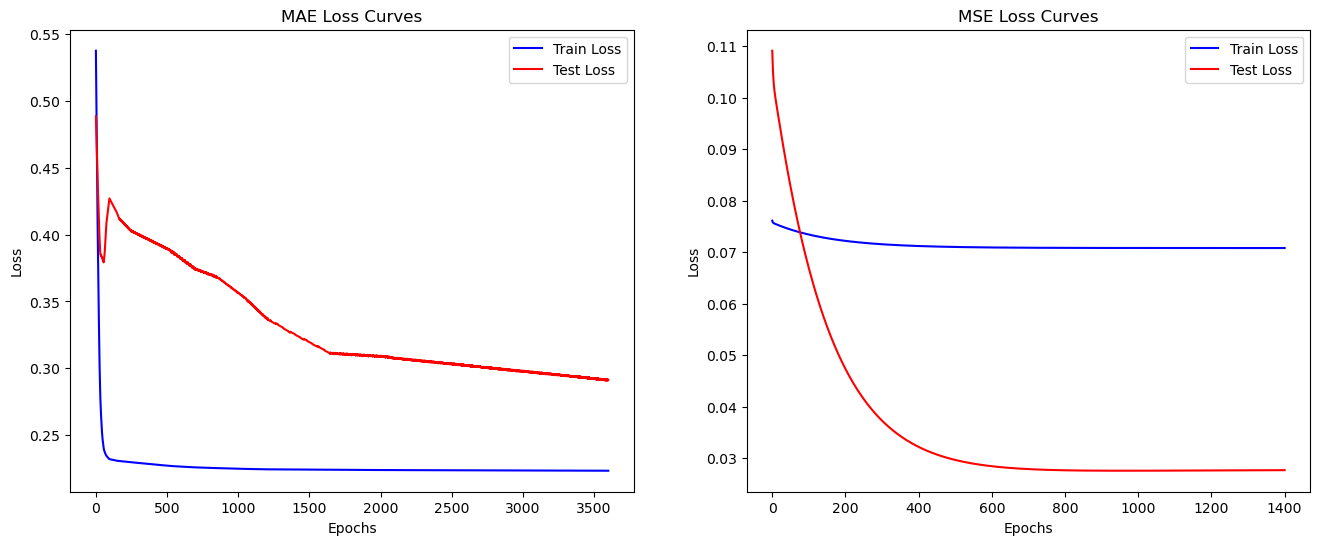

In [12]:
from ploting_utils import plot_loss_curves
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_loss_curves('MAE Loss', range(losses.epochs_run), losses.train_losses, losses.test_losses)
plt.subplot(1,2,2)
plot_loss_curves('MSE Loss', range(losses_mse.epochs_run), losses_mse.train_losses, losses_mse.test_losses)

### Recovered Parameters (MAE vs MSE)

In [13]:
from recovered_parameters import recovered_parameters

recovered_parameters(f'Best_MAE_Loss_10_Noise', normalized_data.X_mean, normalized_data.X_std, normalized_data.y_mean, normalized_data.y_std)
recovered_parameters(f'Best_MSE_Loss_10_Noise', normalized_data.X_mean, normalized_data.X_std, normalized_data.y_mean, normalized_data.y_std)

Recovered Physical Parameters (Best_MAE_Loss_10_Noise Loss):
 a = 3.51, b = 9.00, c = 314.53

Recovered Physical Parameters (Best_MSE_Loss_10_Noise Loss):
 a = 4.84, b = 19.34, c = 303.03



### Visualizing the Predictions (MAE vs MSE)

Text(0.5, 1.0, 'Predicted Free Fall Model (MSE 5% Guassian Noise)')

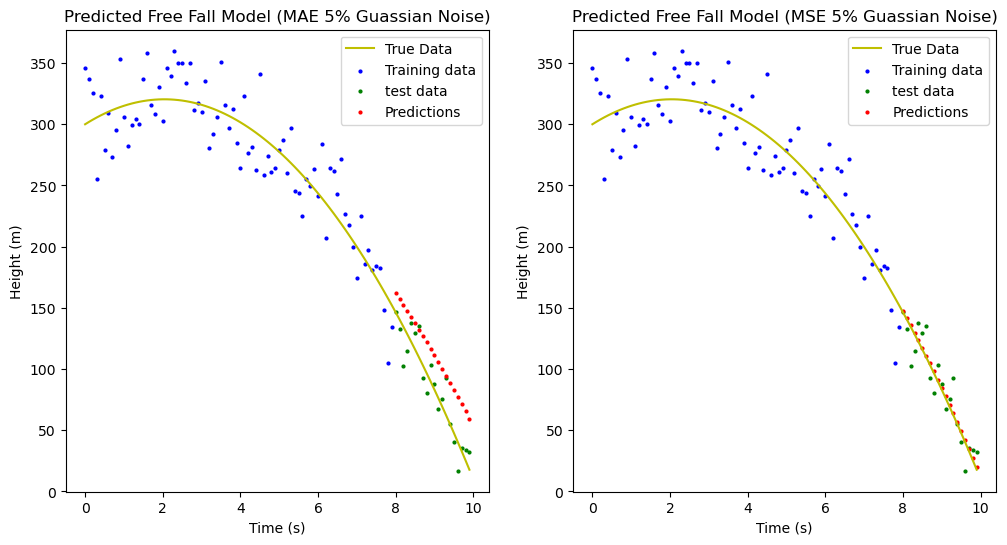

In [14]:
from ploting_utils import plot_predictions
from denormalizing import denormalize_parameters
import matplotlib.pyplot as plt

X_train_denorm = X_train * normalized_data.X_std + normalized_data.X_mean
y_train_denorm = y_train * normalized_data.y_std + normalized_data.y_mean

X_test_denorm = X_test * normalized_data.X_std + normalized_data.X_mean
y_test_denorm = y_test * normalized_data.y_std + normalized_data.y_mean

state_dict = torch.load(f'../models/Best_MAE_Loss_10_Noise.pth', weights_only=True)
model = LinearRegressionModel()
model.load_state_dict(state_dict)
weights = state_dict['linear_layer.weight']
bias = state_dict['linear_layer.bias']

model.eval()
with torch.no_grad():
    preds = model(X_test)

preds_denorm = preds * normalized_data.y_std + normalized_data.y_mean
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(t, y, c ='y', label='True Data')
plot_predictions(X_train_denorm, y_train_denorm, X_test_denorm, y_test_denorm, preds_denorm)
plt.title('Predicted Free Fall Model (MAE 5% Guassian Noise)')

state_dict_mse = torch.load(f'../models/Best_MSE_Loss_10_Noise.pth', weights_only=True)
model_mse = LinearRegressionModel()
model_mse.load_state_dict(state_dict_mse)
weights_mse = state_dict_mse['linear_layer.weight']
bias_mse = state_dict_mse['linear_layer.bias']

model_mse.eval()
with torch.no_grad():
    preds_mse = model_mse(X_test)
preds_denorm_mse = preds_mse * normalized_data.y_std + normalized_data.y_mean
plt.subplot(1,2,2)
plt.plot(t, y, c ='y', label='True Data')
plot_predictions(X_train_denorm, y_train_denorm, X_test_denorm, y_test_denorm, preds_denorm_mse)
plt.title('Predicted Free Fall Model (MSE 5% Guassian Noise)')


## 📊 Reflections on Loss Functions: MAE vs. MSE

Across all three noise levels (5%, 10%, 20%), **Mean Squared Error (MSE)** consistently outperformed **Mean Absolute Error (MAE)** in recovering physically meaningful parameters. This outcome aligns with both theoretical expectations and prior empirical observations:

### 🔍 Why MSE Performs Better in This Context

- **Sensitivity to Gaussian Noise**:  
  MSE is statistically optimal under Gaussian noise assumptions, which matches the noise injected in our experiments. It penalizes larger errors more heavily, making it more responsive to the distribution's variance.

- **Convergence Efficiency**:  
  MAE's gradient is less stable near zero, leading to slower convergence and higher computational cost. While MAE may eventually reach comparable minima, the training time and instability make it less practical for this setup.

- **Outlier Robustness Tradeoff**:  
  MAE is known to be more robust to single outliers, but our noise was uniformly Gaussian—not dominated by extreme values. Thus, MAE’s robustness didn’t translate into better parameter recovery here.

### 🧠 Final Thoughts

While MAE might shine in datasets with sporadic outliers or non-Gaussian noise, in this controlled setting MSE offers a better balance of accuracy and efficiency. **Future experiments could explore hybrid loss functions or adaptive weighting to combine the strengths of both.** (planned)
